# Indexes

Today we're going to be talking about pandas' [`Index`es](http://pandas.pydata.org/pandas-docs/version/0.18.0/api.html#index).
They're essential to pandas, but can be a difficult concept to grasp at first.
I suspect this is partly because they're unlike what you'll find in SQL or R.

`Index`es offer

- a metadata container
- easy label-based row selection and assignment
- easy label-based alignment in operations

One of my first tasks when analyzing a new dataset is to identify a unique identifier for each observation, and set that as the index. It could be a simple integer, or like in our [first post](modern-1.html) it could be several columns (`carrier`, `origin` `dest`, `tail_num` `date`).

To demonstrate the benefits of proper `Index` use, we'll first fetch some weather data from sensors at a bunch of airports across the US.
See [here](https://github.com/akrherz/iem/blob/master/scripts/asos/iem_scraper_example.py) for the example scraper I based this off of.
Those uninterested in the details of fetching and prepping the data and [skip past it](#set-operations).

At a high level, here's how we'll fetch the data: the sensors are broken up by "network" (states).
We'll make one API call per state to get the list of airport IDs per network (using `get_ids` below).
Once we have the IDs, we'll again make one call per state getting the actual observations (in `get_weather`).
Feel free to skim the code below, I'll highlight the interesting bits.


In [4]:
%matplotlib inline

import os
import json
import glob
import datetime
from io import StringIO

import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

sns.set_style('ticks')

# States are broken into networks. The networks have a list of ids, each representing a station.
# We will take that list of ids and pass them as query parameters to the URL we built up ealier.
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY""".split()

# IEM has Iowa AWOS sites in its own labeled network
networks = ['AWOS'] + ['{}_ASOS'.format(state) for state in states]

In [5]:
def get_weather(stations, start=pd.Timestamp('2014-01-01'),
                end=pd.Timestamp('2014-01-31')):
    '''
    Fetch weather data from MESONet between ``start`` and ``stop``.
    '''
    url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
           "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=v"
           "sby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
           "&tz=Etc/UTC&format=comma&latlon=no"
           "&{start:year1=%Y&month1=%m&day1=%d}"
           "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")
    stations = "&".join("station=%s" % s for s in stations)
    weather = (pd.read_csv(url.format(start=start, end=end, stations=stations),
                           comment="#")
                 .rename(columns={"valid": "date"})
                 .rename(columns=str.strip)
                 .assign(date=lambda df: pd.to_datetime(df['date']))
                 .set_index(["station", "date"])
                 .sort_index())
    float_cols = ['tmpf', 'relh', 'sped', 'mslp', 'p01i', 'vsby', "gust_mph"]
    weather[float_cols] = weather[float_cols].apply(pd.to_numeric, errors="corce")
    return weather

In [6]:
def get_ids(network):
    url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
    r = requests.get(url.format(network))
    md = pd.io.json.json_normalize(r.json()['features'])
    md['network'] = network
    return md

There isn't too much in `get_weather` worth mentioning, just grabbing some CSV files from various URLs.
They put metadata in the "CSV"s at the top of the file as lines prefixed by a `#`.
Pandas will ignore these with the `comment='#'` parameter.

I do want to talk briefly about the gem of a method that is [`json_normalize`](http://pandas.pydata.org/pandas-docs/version/0.18.0/generated/pandas.io.json.json_normalize.html)  .
The weather API returns some slightly-nested data.

In [7]:
url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
r = requests.get(url.format("AWOS"))
js = r.json()

js['features'][:2]

[{'geometry': {'coordinates': [-94.2723694444, 43.0796472222],
   'type': 'Point'},
  'id': 'AXA',
  'properties': {'sid': 'AXA', 'sname': 'ALGONA'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [-93.569475, 41.6878083333], 'type': 'Point'},
  'id': 'IKV',
  'properties': {'sid': 'IKV', 'sname': 'ANKENY'},
  'type': 'Feature'}]

If we just pass that list off to the `DataFrame` constructor, we get this.

In [8]:
pd.DataFrame(js['features']).head()

,geometry,id,properties,type
0,"{'type': 'Point', 'coordinates': [-94.27236944...",AXA,"{'sid': 'AXA', 'sname': 'ALGONA'}",Feature
1,"{'type': 'Point', 'coordinates': [-93.569475, ...",IKV,"{'sid': 'IKV', 'sname': 'ANKENY'}",Feature
2,"{'type': 'Point', 'coordinates': [-95.04652777...",AIO,"{'sid': 'AIO', 'sname': 'ATLANTIC'}",Feature
3,"{'type': 'Point', 'coordinates': [-94.92044166...",ADU,"{'sid': 'ADU', 'sname': 'AUDUBON'}",Feature
4,"{'type': 'Point', 'coordinates': [-93.848575, ...",BNW,"{'sid': 'BNW', 'sname': 'BOONE MUNI'}",Feature


In general, DataFrames don't handle nested data that well.
It's often better to normalize it somehow.
In this case, we can "lift"
the nested items (`geometry.coordinates`, `properties.sid`, and `properties.sname`)
up to the top level.

In [9]:
pd.io.json.json_normalize(js['features'])

,geometry.coordinates,geometry.type,id,properties.sid,properties.sname,type
0,"[-94.2723694444, 43.0796472222]",Point,AXA,AXA,ALGONA,Feature
1,"[-93.569475, 41.6878083333]",Point,IKV,IKV,ANKENY,Feature
2,"[-95.0465277778, 41.4058805556]",Point,AIO,AIO,ATLANTIC,Feature
3,"[-94.9204416667, 41.6993527778]",Point,ADU,ADU,AUDUBON,Feature
4,"[-93.848575, 42.0485694444]",Point,BNW,BNW,BOONE MUNI,Feature
...,...,...,...,...,...,...
40,"[-95.4112333333, 40.753275]",Point,SDA,SDA,SHENANDOAH MUNI,Feature
41,"[-95.2399194444, 42.5972277778]",Point,SLB,SLB,Storm Lake,Feature
42,"[-92.0248416667, 42.2175777778]",Point,VTI,VTI,VINTON,Feature
43,"[-91.6748111111, 41.2751444444]",Point,AWG,AWG,WASHINGTON,Feature


Sure, it's not *that* difficult to write a quick for loop or list comprehension to extract those,
but that gets tedious.
If we were using the latitude and longitude data, we would want to split
the `geometry.coordinates` column into two. But we aren't so we won't.

Going back to the task, we get the airport IDs for every network (state)
with `get_ids`. Then we pass those IDs into `get_weather` to fetch the
actual weather data.

In [13]:
import os

ids = pd.concat([get_ids(network) for network in networks], ignore_index=True)
gr = ids.groupby('network')

store = 'data/weather.h5'

if not os.path.exists(store):
    os.makedirs("data/weather", exist_ok=True)

    for k, v in gr:
        weather = get_weather(v['id'])
        weather.to_csv("data/weather/{}.csv".format(k))

    weather = pd.concat([
        pd.read_csv(f, parse_dates=['date'], index_col=['station', 'date'])
        for f in glob.glob('data/weather/*.csv')
    ]).sort_index()

    weather.to_hdf("data/weather.h5", "weather")
else:
    weather = pd.read_hdf("data/weather.h5", "weather")

In [14]:
weather.head()

tmpf   relh  sped  mslp  p01i  vsby  gust_mph  \
station date                                                                  
01M     2014-01-01 00:15:00  33.80  85.86   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:35:00  33.44  87.11   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:55:00  32.54  90.97   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:15:00  31.82  93.65   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:35:00  32.00  92.97   0.0   NaN   0.0  10.0       NaN   

                            skyc1 skyc2 skyc3  
station date                                   
01M     2014-01-01 00:15:00   CLR     M     M  
        2014-01-01 00:35:00   CLR     M     M  
        2014-01-01 00:55:00   CLR     M     M  
        2014-01-01 01:15:00   CLR     M     M  
        2014-01-01 01:35:00   CLR     M     M

OK, that was a bit of work. Here's a plot to reward ourselves.

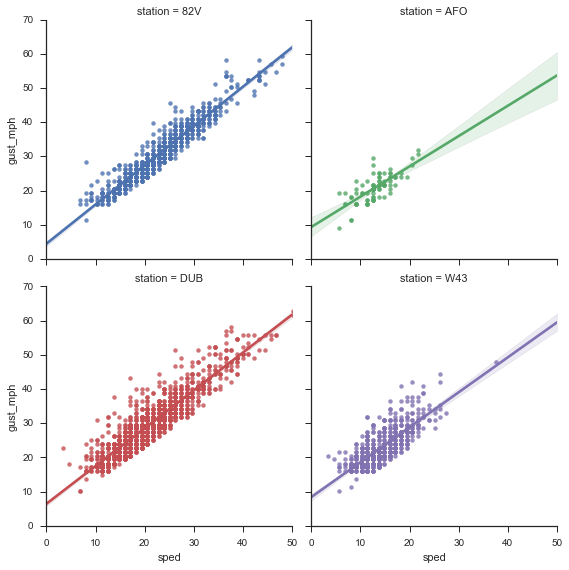

In [15]:
airports = ['W43', 'AFO', '82V', 'DUB']

g = sns.FacetGrid(weather.loc[airports].reset_index(),
                  col='station', hue='station', col_wrap=2, size=4)
g.map(sns.regplot, 'sped', 'gust_mph')

## Set Operations

Indexes are set-like (technically *multi*sets, since you can have duplicates), so they support most python `set` operations. Since indexes are immutable you won't find any of the inplace `set` operations.
One other difference is that since `Index`es are also array-like, you can't use some infix operators like `-` for `difference`. If you have a numeric index it is unclear whether you intend to perform math operations or set operations.
You can use `&` for intersection, `|` for union, and `^` for symmetric difference though, since there's no ambiguity.

For example, lets find the set of airports that we have both weather and flight information on. Since `weather` had a MultiIndex of `airport, datetime`, we'll use the `levels` attribute to get at the airport data, separate from the date data.

In [18]:
# Bring in the flights data

flights = pd.read_hdf('data/flights.h5', 'flights')

weather_locs = weather.index.levels[0]
# The `categories` attribute of a Categorical is an Index
origin_locs = flights.origin.cat.categories
dest_locs = flights.dest.cat.categories

airports = weather_locs & origin_locs & dest_locs
airports

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'AEX', 'AGS', 'ALB',
       ...
       'TUL', 'TUS', 'TVC', 'TWF', 'TXK', 'TYR', 'TYS', 'VLD', 'VPS', 'XNA'],
      dtype='object', length=267)

In [20]:
print("Weather, no flights:\n\t", weather_locs.difference(origin_locs | dest_locs), end='\n\n')

print("Flights, no weather:\n\t", (origin_locs | dest_locs).difference(weather_locs), end='\n\n')

print("Dropped Stations:\n\t", (origin_locs | dest_locs) ^ weather_locs)

Weather, no flights:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y50', 'Y51', 'Y63', 'Y70', 'YIP', 'YKM', 'YKN', 'YNG', 'ZPH', 'ZZV'],
      dtype='object', length=1909)

Flights, no weather:
	 Index(['ADK', 'ADQ', 'ANC', 'BET', 'BKG', 'BQN', 'BRW', 'CDV', 'CLD', 'FAI',
       'FCA', 'GUM', 'HNL', 'ITO', 'JNU', 'KOA', 'KTN', 'LIH', 'MQT', 'OGG',
       'OME', 'OTZ', 'PPG', 'PSE', 'PSG', 'SCC', 'SCE', 'SIT', 'SJU', 'STT',
       'STX', 'WRG', 'YAK', 'YUM'],
      dtype='object')

Dropped Stations:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y63', 'Y70', 'YAK', 'YIP', 'YKM', 'YKN', 'YNG', 'YUM', 'ZPH', 'ZZV'],
      dtype='object', length=1943)


## Flavors

Pandas has many subclasses of the regular `Index`, each tailored to a specific kind of data.
Most of the time these will be created for you automatically, so you don't have to worry about which one to choose.

1. [`Index`](http://pandas.pydata.org/pandas-docs/version/0.18.0/generated/pandas.Index.html#pandas.Index)
2. `Int64Index`
3. `RangeIndex`: Memory-saving special case of `Int64Index`
4. `FloatIndex`
5. `DatetimeIndex`: Datetime64[ns] precision data
6. `PeriodIndex`: Regularly-spaced, arbitrary precision datetime data.
7. `TimedeltaIndex`
8. `CategoricalIndex`
9. `MultiIndex`

You will sometimes create a `DatetimeIndex` with [`pd.date_range`](http://pandas.pydata.org/pandas-docs/version/0.18.0/generated/pandas.date_range.html) ([`pd.period_range`](http://pandas.pydata.org/pandas-docs/version/0.18.0/generated/pandas.period_range.html) for `PeriodIndex`).
And you'll sometimes make a `MultiIndex` directly too (I'll have an example of this in my post on performace).

Some of these specialized index types are purely optimizations; others use information about the data to provide additional methods.
And while you might occasionally work with indexes directly (like the set operations above), most of they time you'll be operating on a Series or DataFrame, which in turn makes use of its Index.


### Row Slicing
We saw in part one that they're great for making *row* subsetting as easy as column subsetting.

In [21]:
weather.loc['DSM'].head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
date,,,,,,,,,,
2014-01-01 00:54:00,10.94,72.79,10.3,1024.9,0.0,10.0,NaN,FEW,M,M
2014-01-01 01:54:00,10.94,72.79,11.4,1025.4,0.0,10.0,NaN,OVC,M,M
2014-01-01 02:54:00,10.94,72.79,8.0,1025.3,0.0,10.0,NaN,BKN,M,M
2014-01-01 03:54:00,10.94,72.79,9.1,1025.3,0.0,10.0,NaN,OVC,M,M
2014-01-01 04:54:00,10.04,72.69,9.1,1024.7,0.0,10.0,NaN,BKN,M,M


Without indexes we'd probably resort to boolean masks.

In [22]:
weather2 = weather.reset_index()
weather2[weather2['station'] == 'DSM'].head()

,station,date,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
884855,DSM,2014-01-01 00:54:00,10.94,72.79,10.3,1024.9,0.0,10.0,NaN,FEW,M,M
884856,DSM,2014-01-01 01:54:00,10.94,72.79,11.4,1025.4,0.0,10.0,NaN,OVC,M,M
884857,DSM,2014-01-01 02:54:00,10.94,72.79,8.0,1025.3,0.0,10.0,NaN,BKN,M,M
884858,DSM,2014-01-01 03:54:00,10.94,72.79,9.1,1025.3,0.0,10.0,NaN,OVC,M,M
884859,DSM,2014-01-01 04:54:00,10.04,72.69,9.1,1024.7,0.0,10.0,NaN,BKN,M,M


Slightly less convenient, but still doable.

### Indexes for Easier Arithmetic, Analysis

It's nice to have your metadata (labels on each observation) next to you actual values. But if you store them in an array, they'll get in the way of your operations.
Say we wanted to translate the Fahrenheit temperature to Celsius.

In [23]:
# With indecies
temp = weather['tmpf']

c = (temp - 32) * 5 / 9
c.to_frame()

tmpf
station date                     
01M     2014-01-01 00:15:00   1.0
        2014-01-01 00:35:00   0.8
        2014-01-01 00:55:00   0.3
        2014-01-01 01:15:00  -0.1
        2014-01-01 01:35:00   0.0
...                           ...
ZZV     2014-01-30 19:53:00  -2.8
        2014-01-30 20:53:00  -2.2
        2014-01-30 21:53:00  -2.2
        2014-01-30 22:53:00  -2.8
        2014-01-30 23:53:00  -1.7

[3303647 rows x 1 columns]

In [24]:
# without
temp2 = weather.reset_index()[['station', 'date', 'tmpf']]

temp2['tmpf'] = (temp2['tmpf'] - 32) * 5 / 9
temp2.head()

,station,date,tmpf
0,01M,2014-01-01 00:15:00,1.0
1,01M,2014-01-01 00:35:00,0.8
2,01M,2014-01-01 00:55:00,0.3
3,01M,2014-01-01 01:15:00,-0.1
4,01M,2014-01-01 01:35:00,0.0


Again, not terrible, but not as good.
And, what if you had wanted to keep Fahrenheit around as well, instead of overwriting it like we did?
Then you'd need to make a copy of everything, including the `station` and `date` columns.
We don't have that problem, since indexes are immutable and safely shared between DataFrames / Series.

In [25]:
temp.index is c.index

True

### Indexes for Alignment

I've saved the best for last.
Automatic alignment, or reindexing, is fundamental to pandas.

All binary operations (add, multiply, etc.) between Series/DataFrames first *align* and then proceed.

Let's suppose we have hourly observations on temperature and windspeed.
And suppose some of the observations were invalid, and not reported (simulated below by sampling from the full dataset). We'll assume the missing windspeed observations were potentially different from the missing temperature observations.

In [26]:
dsm = weather.loc['DSM']

hourly = dsm.resample('H').mean()

temp = hourly['tmpf'].sample(frac=.5, random_state=1).sort_index()
sped = hourly['sped'].sample(frac=.5, random_state=2).sort_index()

In [27]:
temp.head().to_frame()

,tmpf
date,
2014-01-01 00:00:00,10.94
2014-01-01 02:00:00,10.94
2014-01-01 03:00:00,10.94
2014-01-01 04:00:00,10.04
2014-01-01 05:00:00,10.04


In [28]:
sped.head()

date
2014-01-01 01:00:00    11.4
2014-01-01 02:00:00     8.0
2014-01-01 03:00:00     9.1
2014-01-01 04:00:00     9.1
2014-01-01 05:00:00    10.3
Name: sped, dtype: float64

Notice that the two indexes aren't identical.

Suppose that the `windspeed : temperature` ratio is meaningful.
When we go to compute that, pandas will automatically align the two by index label.

In [29]:
sped / temp

date
2014-01-01 00:00:00         NaN
2014-01-01 01:00:00         NaN
2014-01-01 02:00:00    0.731261
2014-01-01 03:00:00    0.831810
2014-01-01 04:00:00    0.906375
                         ...   
2014-01-30 13:00:00         NaN
2014-01-30 14:00:00    0.584712
2014-01-30 17:00:00         NaN
2014-01-30 21:00:00         NaN
2014-01-30 23:00:00         NaN
dtype: float64

This lets you focus on doing the operation, rather than manually aligning things, ensuring that the arrays are the same length and in the same order.
By deault, missing values are inserted where the two don't align.
You can use the method version of any binary operation to specify a `fill_value`

In [30]:
sped.div(temp, fill_value=1)

date
2014-01-01 00:00:00     0.091408
2014-01-01 01:00:00    11.400000
2014-01-01 02:00:00     0.731261
2014-01-01 03:00:00     0.831810
2014-01-01 04:00:00     0.906375
                         ...    
2014-01-30 13:00:00     0.027809
2014-01-30 14:00:00     0.584712
2014-01-30 17:00:00     0.023267
2014-01-30 21:00:00     0.035663
2014-01-30 23:00:00    13.700000
dtype: float64

And since I couldn't find anywhere else to put it, you can control the axis the operation is aligned along as well.

In [31]:
hourly.div(sped, axis='index')

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph
date,,,,,,,
2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,0.959649,6.385088,1.0,89.947368,0.0,0.877193,NaN
2014-01-01 02:00:00,1.367500,9.098750,1.0,128.162500,0.0,1.250000,NaN
2014-01-01 03:00:00,1.202198,7.998901,1.0,112.670330,0.0,1.098901,NaN
2014-01-01 04:00:00,1.103297,7.987912,1.0,112.604396,0.0,1.098901,NaN
...,...,...,...,...,...,...,...
2014-01-30 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The non row-labeled version of this is messy.

In [32]:
temp2 = temp.reset_index()
sped2 = sped.reset_index()

# Find rows where the operation is defined
common_dates = pd.Index(temp2.date) & sped2.date
pd.concat([
    # concat to not lose date information
    sped2.loc[sped2['date'].isin(common_dates), 'date'],
    (sped2.loc[sped2.date.isin(common_dates), 'sped'] /
     temp2.loc[temp2.date.isin(common_dates), 'tmpf'])],
    axis=1).dropna(how='all')

,date,0
1,2014-01-01 02:00:00,0.731261
2,2014-01-01 03:00:00,0.831810
3,2014-01-01 04:00:00,0.906375
4,2014-01-01 05:00:00,1.025896
8,2014-01-01 13:00:00,NaN
...,...,...
351,2014-01-29 23:00:00,0.535609
354,2014-01-30 05:00:00,0.487735
356,2014-01-30 09:00:00,NaN
357,2014-01-30 10:00:00,0.618939


And we have a bug in there. Can you spot it?
I only grabbed the dates from `sped2` in the line `sped2.loc[sped2['date'].isin(common_dates), 'date']`.
Really that should be `sped2.loc[sped2.date.isin(common_dates)] | temp2.loc[temp2.date.isin(common_dates)]`.
But I think leaving the buggy version states my case even more strongly. The `temp / sped` version where pandas aligns everything is better.

## Merging

There are two ways of merging DataFrames / Series in pandas.

1. Relational Database style with `pd.merge`
2. Array style with `pd.concat`

Personally, I think in terms of the `concat` style.
I learned pandas before I ever really used SQL, so it comes more naturally to me I suppose.

### Concat Version

In [36]:
pd.concat([temp, sped], axis=1).head()

,tmpf,sped
date,,
2014-01-01 00:00:00,10.94,NaN
2014-01-01 01:00:00,NaN,11.4
2014-01-01 02:00:00,10.94,8.0
2014-01-01 03:00:00,10.94,9.1
2014-01-01 04:00:00,10.04,9.1


The `axis` parameter controls how the data should be stacked, `0` for vertically, `1` for horizontally.
The `join` parameter controls the merge behavior on the shared axis, (the Index for `axis=1`). By default it's like a union of the two indexes, or an outer join.

In [38]:
pd.concat([temp, sped], axis=1, join='inner')

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.000
2014-01-01 03:00:00,10.94,9.100
2014-01-01 04:00:00,10.04,9.100
2014-01-01 05:00:00,10.04,10.300
2014-01-01 13:00:00,8.96,13.675
...,...,...
2014-01-29 23:00:00,35.96,18.200
2014-01-30 05:00:00,33.98,17.100
2014-01-30 09:00:00,35.06,16.000


### Merge Version

Since we're joining by index here the merge version is quite similar.
We'll see an example later of a one-to-many join where the two differ.

In [39]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True).head()

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.000
2014-01-01 03:00:00,10.94,9.100
2014-01-01 04:00:00,10.04,9.100
2014-01-01 05:00:00,10.04,10.300
2014-01-01 13:00:00,8.96,13.675


In [41]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True,
         how='outer').head()

,tmpf,sped
date,,
2014-01-01 00:00:00,10.94,NaN
2014-01-01 01:00:00,NaN,11.4
2014-01-01 02:00:00,10.94,8.0
2014-01-01 03:00:00,10.94,9.1
2014-01-01 04:00:00,10.04,9.1


Like I said, I typically prefer `concat` to `merge`.
The exception here is one-to-many type joins. Let's walk through one of those,
where we join the flight data to the weather data.
To focus just on the merge, we'll aggregate hour weather data to be daily, rather than trying to find the closest recorded weather observation to each departure (you could do that, but it's not the focus right now). We'll then join the one `(airport, date)` record to the many `(airport, date, flight)` records.

Quick tangent, to get the weather data to daily frequency, we'll need to resample (more on that in the timeseries section). The resample essentially splits the recorded values into daily buckets and computes the aggregation function on each bucket. The only wrinkle is that we have to resample *by station*, so we'll use the `pd.TimeGrouper` helper.

In [42]:
idx_cols = ['unique_carrier', 'origin', 'dest', 'tail_num', 'fl_num', 'fl_date']
data_cols = ['crs_dep_time', 'dep_delay', 'crs_arr_time', 'arr_delay',
             'taxi_out', 'taxi_in', 'wheels_off', 'wheels_on', 'distance']

df = flights.set_index(idx_cols)[data_cols].sort_index()

In [43]:
def mode(x):
    '''
    Arbitrarily break ties.
    '''
    return x.value_counts().index[0]

aggfuncs = {'tmpf': 'mean', 'relh': 'mean',
            'sped': 'mean', 'mslp': 'mean',
            'p01i': 'mean', 'vsby': 'mean',
            'gust_mph': 'mean', 'skyc1': mode,
            'skyc2': mode, 'skyc3': mode}
# TimeGrouper works on a DatetimeIndex, so we move `station` to the
# columns and then groupby it as well.
daily = (weather.reset_index(level="station")
                .groupby([pd.TimeGrouper('1d'), "station"])
                .agg(aggfuncs))

daily.head()

mslp   gust_mph       vsby  p01i       relh skyc3  \
date       station                                                      
2014-01-01 01M       NaN        NaN   9.229167   0.0  81.117917     M   
           04V       NaN  31.307143   9.861111   0.0  72.697778     M   
           04W       NaN        NaN  10.000000   0.0  69.908056     M   
           05U       NaN        NaN   9.929577   0.0  71.519859     M   
           06D       NaN        NaN   9.576389   0.0  73.784179     M   

                         sped       tmpf skyc1 skyc2  
date       station                                    
2014-01-01 01M       2.262500  35.747500   CLR     M  
           04V      11.131944  18.350000   CLR     M  
           04W       3.601389  -9.075000   OVC     M  
           05U       3.770423  26.321127   CLR     M  
           06D       5.279167 -11.388060   CLR     M

Now that we have daily flight and weather data, we can merge.
We'll use the `on` keyword to indicate the columns we'll merge on (this is like a `USING (...)` SQL statement), we just have to make sure the names align.

### The merge version

In [44]:
m = pd.merge(flights, daily.reset_index().rename(columns={'date': 'fl_date', 'station': 'origin'}),
             on=['fl_date', 'origin']).set_index(idx_cols).sort_index()

m.head()

airline_id  \
unique_carrier origin dest tail_num fl_num fl_date                  
AA             ABQ    DFW  N200AA   1090   2014-01-27       19805   
                                    1662   2014-01-06       19805   
                           N202AA   1332   2014-01-27       19805   
                           N426AA   1467   2014-01-15       19805   
                                    1662   2014-01-09       19805   

                                                       origin_airport_id  \
unique_carrier origin dest tail_num fl_num fl_date                         
AA             ABQ    DFW  N200AA   1090   2014-01-27              10140   
                                    1662   2014-01-06              10140   
                           N202AA   1332   2014-01-27              10140   
                           N426AA   1467   2014-01-15              10140   
                                    1662   2014-01-09              10140   

                                                       origin_airport_seq_id  \
unique_carrier origin dest tail_num fl_num fl_date                             
AA             ABQ    DFW  N200AA   1090   2014-01-27                1014002   
                                    1662   2014-01-06                1014002   
                           N202AA   1332   2014-01-27                1014002   
                           N426AA   1467   2014-01-15                1014002   
                                    1662   2014-01-09                1014002   

                                                       origin_city_market_id  \
unique_carrier origin dest tail_num fl_num fl_date                             
AA             ABQ    DFW  N200AA   1090   2014-01-27                  30140   
                                    1662   2014-01-06                  30140   
                           N202AA   1332   2014-01-27                  30140   
                           N426AA   1467   2014-01-15                  30140   
                                    1662   2014-01-09                  30140   

                                                      origin_city_name  \
unique_carrier origin dest tail_num fl_num fl_date                       
AA             ABQ    DFW  N200AA   1090   2014-01-27      Albuquerque   
                                    1662   2014-01-06      Albuquerque   
                           N202AA   1332   2014-01-27      Albuquerque   
                           N426AA   1467   2014-01-15      Albuquerque   
                                    1662   2014-01-09      Albuquerque   

                                                      origin_state_nm  \
unique_carrier origin dest tail_num fl_num fl_date                      
AA             ABQ    DFW  N200AA   1090   2014-01-27      New Mexico   
                                    1662   2014-01-06      New Mexico   
                           N202AA   1332   2014-01-27      New Mexico   
                           N426AA   1467   2014-01-15      New Mexico   
                                    1662   2014-01-09      New Mexico   

                                                       dest_airport_id  \
unique_carrier origin dest tail_num fl_num fl_date                       
AA             ABQ    DFW  N200AA   1090   2014-01-27            11298   
                                    1662   2014-01-06            11298   
                           N202AA   1332   2014-01-27            11298   
                           N426AA   1467   2014-01-15            11298   
                                    1662   2014-01-09            11298   

                                                       dest_airport_seq_id  \
unique_carrier origin dest tail_num fl_num fl_date                           
AA             ABQ    DFW  N200AA   1090   2014-01-27              1129803   
                                    1662   2014-01-06              1129803   
                           N202AA   1332   2014-01-27 

Since data-wrangling on its own is never the goal, let's do some quick analysis.
Seaborn makes it easy to explore bivariate relationships.

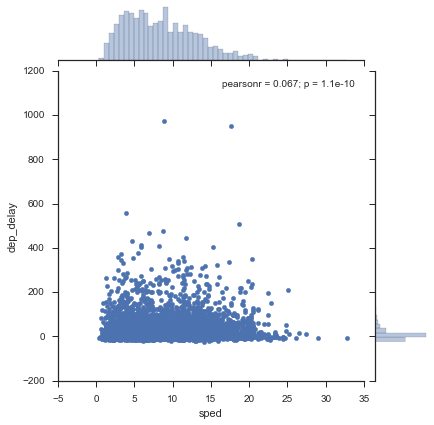

In [45]:
m.sample(n=10000).pipe((sns.jointplot, 'data'), 'sped', 'dep_delay');

Looking at the various [sky coverage states](https://en.wikipedia.org/wiki/METAR#Cloud_reporting):



In [47]:
m.groupby('skyc1').dep_delay.agg(['mean', 'count']).sort_values(by='mean')

,mean,count
skyc1,,
M,9.621053,95
CLR,11.376158,111469
FEW,16.903166,171086
BKN,18.030369,48010
SCT,18.596965,15815
OVC,21.176461,55780
VV,29.403916,10215


In [48]:
import statsmodels.api as sm

Statsmodels (via [patsy](http://patsy.readthedocs.org/) can automatically convert dummy data to dummy variables in a formula with the `C` function).

In [49]:
mod = sm.OLS.from_formula('dep_delay ~ C(skyc1) + distance + tmpf + relh + sped + mslp', data=m)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dep_delay   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     956.6
Date:                Sat, 25 Jun 2016   Prob (F-statistic):               0.00
Time:                        15:57:46   Log-Likelihood:            -2.1454e+06
No. Observations:              410372   AIC:                         4.291e+06
Df Residuals:                  410360   BIC:                         4.291e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -324.1257     10.827    -29.937      0.000    -345.346    -302.905
C(skyc1)[T.CLR]    -3.6147      0.260    -13.915      0.000      -4.124      -3.106
C(skyc1)[T.FEW]    -0.3676      0.235     -1.565      0.118      -0.828       0.093
C(skyc1)[T.M]       2.2349      6.727      0.332      0.740     -10.951      15.420
C(skyc1)[T.OVC]     0.1272      0.286      0.445      0.656      -0.433       0.687
C(skyc1)[T.SCT]     2.0439      0.415      4.920      0.000       1.230       2.858
C(skyc1)[T.VV ]     7.8404      0.501     15.660      0.000       6.859       8.822
distance            0.0008      0.000      6.256      0.000       0.001       0.001
tmpf               -0.1858      0.005    -38.707      0.000      -0.195      -0.176
relh                0.1715      0.004     40.367      0.000       0.163       0.180
sped                0.6154      0.018     34.051      0.000       0.580       0.651
mslp                0.3262      0.010     31.221      0.000       0.306       0.347
==============================================================================
Omnibus:                   456723.470   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         76114991.206
Skew:                           5.536   Prob(JB):                         0.00
Kurtosis:                      68.794   Cond. No.                     2.07e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

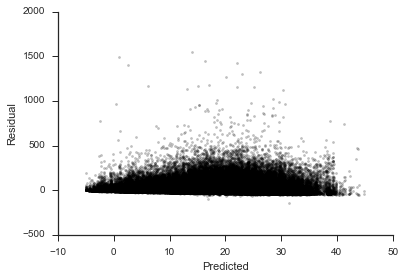

In [50]:
fig, ax = plt.subplots()
ax.scatter(res.fittedvalues, res.resid, color='k', marker='.', alpha=.25)
ax.set(xlabel='Predicted', ylabel='Residual')
sns.despine()

Those residuals should look like white noise.
Looks like our linear model isn't flexible enough to model the delays,
but I think that's enough for now.

---

We'll talk more about indexes in the Tidy Data and Reshaping section.
[Let me know](http://twitter.com/tomaugspurger) if you have any feedback.
Thanks for reading!